<table width=100%>
<tr>
    <td><h1 style="text-align: left; font-size:300%;">
        Feature Engineering - Hands On Solutions
    </h1></td>
    <td width="30%">
    <div style="text-align: right">
    <b> Practical Data Science Lessons</b><br><br>
    <b> Riccardo Bertoglio</b><br>
    <a href="mailto:riccardo.bertoglio@polimi.it">riccardo.bertoglio@polimi.it</a><br>
    </div>
</tr>
</table>

In this exercise, you will work with data from the **[Ames Housing Dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)**.

The Ames Housing Dataset contains houses features to predict their prices. The Ames data fits into the long-established **hedonic pricing method**. Hedonic pricing is a model that identifies price factors according to the premise that **price is determined both by internal characteristics of the good being sold and external factors affecting it**. 

It is therefore useful to regurgitate the usual suspects affecting house prices. **If the dependent (or target) variable is the sale price, then naturally the larger the house the higher the price, all else being equal**. That should be as self-evident as asserting that an 18-inch pizza will probably cost more than a 12-inch pizza. So property size measures will be key variables, and there are several such variables in the Ames dataset. **A more interesting question might be how and why the price per square foot might differ from house to house**, which is like asking why certain pizzerias are able to charge a higher price per slice. Real estate professionals too tend to focus on price per square foot (or meter) instead of the overall price.

**Any home buyer would expect neighborhood location and associated characteristics, such as access to amenities (e.g. good schools, leisure facilities), transport networks (e.g. near a metro station), neighborhood aesthetics (e.g. tree-lined streets, handsome houses), and socioeconomic prestige among others, to have an impact on house prices**.

Another group of **factors commonly said to be important for determining housing prices is the number of rooms, particularly bedrooms and bathrooms, and the condition of the kitchen. Beyond this, the age and physical condition of the house are also important, as are the construction materials and any structural improvements to the property**.

The factors that effect housing prices may be **summarized as property size, location desirability, nearby amenities, number of rooms, construction materials, and age and condition of the structure**. Armed with this prior research, let's analyze the data!

![Ames Housing dataset image](https://i.imgur.com/lTJVG4e.png)


# Step 1 - Preliminaries #
## Imports and Configuration ##

We'll start by importing the packages and setting some notebook defaults:

In [1]:
!pip install xgboost

In [2]:
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype

from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor


# Set Matplotlib defaults
plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Mute warnings
warnings.filterwarnings('ignore')

## Data Preprocessing

Before you can do any feature engineering, you need to *preprocess* the data to get it in a form suitable for analysis. For the *Ames* dataset, you'll need to:
- **Load** the data from CSV files
- **Clean** the data to fix any errors or inconsistencies
- **Encode** the statistical data type (numeric, categorical)
- **Impute** any missing values

You'll wrap all these steps up in a function, which will make easy for you to get a fresh dataframe whenever you need.

### Load the data

In [3]:
data_dir = Path("./data")
df_train = pd.read_csv(data_dir / "train.csv", index_col="Id")
df_test = pd.read_csv(data_dir / "test.csv", index_col="Id")
# Merge the splits so we can process them together
df = pd.concat([df_train, df_test])

In [4]:
df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [5]:
len(df.columns)

80

In [6]:
len(df)

2919

### Clean Data

Some of the categorical features in this dataset have what are apparently typos in their categories:

In [7]:
df.Exterior2nd.unique()

array(['VinylSd', 'MetalSd', 'Wd Shng', 'HdBoard', 'Plywood', 'Wd Sdng',
       'CmentBd', 'BrkFace', 'Stucco', 'AsbShng', 'Brk Cmn', 'ImStucc',
       'AsphShn', 'Stone', 'Other', 'CBlock', nan], dtype=object)

Compare these unique values to `data_description.txt` and find what needs cleaning.

Write a `clean()` function to:
- fix the typo of the `Exterior2nd` column
- fix the corrupted values of `GarageYrBlt` (years greater than 2010)
- replace the columns' names that begin with numbers ("1stFlrSF", "2ndFlrSF", "3SsnPorch") with their word spelling ("FirstFlrSF", "SecondFlrSF", and "Threeseasonporch") by using the pandas `rename()` function

In [8]:
def clean(df):
    df["Exterior2nd"] = df["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    # Some values of GarageYrBlt are corrupt, so we'll replace them
    # with the year the house was built
    df["GarageYrBlt"] = df["GarageYrBlt"].where(df.GarageYrBlt <= 2010, df.YearBuilt)
    # Names beginning with numbers are awkward to work with
    df.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
    }, inplace=True,
    )
    return df


In [9]:
clean(df)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN


### Encode the Data Type

Pandas has Python types corresponding to the standard data types (numeric, categorical, etc.). Encoding each feature with its correct type helps ensure each feature is treated appropriately by whatever functions we use, and makes it easier for us to apply transformations consistently. This cell defines the `encode` function:

In [10]:

# The numeric features are already encoded correctly (`float` for
# continuous, `int` for discrete), but the categoricals you'll need to
# do yourselves. Note in particular, that the `MSSubClass` feature is
# read as an `int` type, but is actually a (nominative) categorical.

# The nominative (unordered) categorical features
features_nom = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig", "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", "Heating", "CentralAir", "GarageType", "MiscFeature", "SaleType", "SaleCondition"]


# The ordinal (ordered) categorical features 

# Pandas calls the categories "levels"
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(10))

ordered_levels = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

# Add a None level for missing values
ordered_levels = {key: ["None"] + value for key, value in
                  ordered_levels.items()}


def encode(df):
    # Nominal categories
    for name in features_nom:
        df[name] = df[name].astype("category")
        # Add a None category for missing values
        if "None" not in df[name].cat.categories:
            df[name] = df[name].cat.add_categories("None")
    # Ordinal categories
    for name, levels in ordered_levels.items():
        df[name] = df[name].astype(CategoricalDtype(levels,
                                                    ordered=True))
    return df


In [11]:
encode(df)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN


### Handle Missing Values

Handling missing values now will make the feature engineering go more smoothly. You'll impute `0` for missing numeric values and `"None"` for missing categorical values. You might like to experiment with other imputation strategies. In particular, you could try creating "missing value" indicators: `1` whenever a value was imputed and `0` otherwise. Also, you can think of dropping columns with a percentage of missing values higher than a threshold, like 15%.

**Hint:** Use the `select_dtypes` Pandas function to return a subset of the DataFrame’s columns based on the column dtypes.

In [12]:
def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df


In [13]:
impute(df)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,2,2008,WD,Normal,208500.0
2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0,None,None,None,0,5,2007,WD,Normal,181500.0
3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,0,None,None,None,0,9,2008,WD,Normal,223500.0
4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,0,None,None,None,0,2,2006,WD,Abnorml,140000.0
5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,0,None,None,None,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,RM,21.0,1936,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,6,2006,WD,Normal,0.0
2916,160,RM,21.0,1894,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,4,2006,WD,Abnorml,0.0
2917,20,RL,160.0,20000,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,9,2006,WD,Abnorml,0.0


### Load Data Function

After reading the CSV file, we'll apply three preprocessing steps, `clean`, `encode`, and `impute`, and then create the data splits: one (`df_train`) for training the model, and one (`df_test`) for making the predictions:

In [14]:
def load_data():
    # Read data
    data_dir = Path("./data")
    df_train = pd.read_csv(data_dir / "train.csv", index_col="Id")
    df_test = pd.read_csv(data_dir / "test.csv", index_col="Id")
    # Merge the splits so we can process them together
    df = pd.concat([df_train, df_test])
    # Preprocessing
    df = clean(df)
    df = encode(df)
    df = impute(df)
    # Reform splits
    df_train = df.loc[df_train.index, :]
    df_test = df.loc[df_test.index, :]
    return df_train, df_test


In [15]:
df_train, df_test = load_data()

Run this cell if you'd like to see what they contain. Notice that `df_test` is
missing values for `SalePrice`. (`NA`s were willed with 0's in the imputation step.)

In [16]:
# Peek at the values
display(df_train)
display(df_test)

# Display information about dtypes and missing values
display(df_train.info())
display(df_test.info())

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,2,2008,WD,Normal,208500.0
2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0,None,None,None,0,5,2007,WD,Normal,181500.0
3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,0,None,None,None,0,9,2008,WD,Normal,223500.0
4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,0,None,None,None,0,2,2006,WD,Abnorml,140000.0
5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,0,None,None,None,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,8,2007,WD,Normal,175000.0
1457,20,RL,85.0,13175,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,MnPrv,None,0,2,2010,WD,Normal,210000.0
1458,70,RL,66.0,9042,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,GdPrv,Shed,2500,5,2010,WD,Normal,266500.0


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,MnPrv,None,0,6,2010,WD,Normal,0.0
1462,20,RL,81.0,14267,Pave,None,IR1,Lvl,AllPub,Corner,...,0,None,None,Gar2,12500,6,2010,WD,Normal,0.0
1463,60,RL,74.0,13830,Pave,None,IR1,Lvl,AllPub,Inside,...,0,None,MnPrv,None,0,3,2010,WD,Normal,0.0
1464,60,RL,78.0,9978,Pave,None,IR1,Lvl,AllPub,Inside,...,0,None,None,None,0,6,2010,WD,Normal,0.0
1465,120,RL,43.0,5005,Pave,None,IR1,HLS,AllPub,Inside,...,0,None,None,None,0,1,2010,WD,Normal,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,RM,21.0,1936,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,6,2006,WD,Normal,0.0
2916,160,RM,21.0,1894,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,4,2006,WD,Abnorml,0.0
2917,20,RL,160.0,20000,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,9,2006,WD,Abnorml,0.0


<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   MSSubClass        1460 non-null   category
 1   MSZoning          1460 non-null   category
 2   LotFrontage       1460 non-null   float64 
 3   LotArea           1460 non-null   int64   
 4   Street            1460 non-null   category
 5   Alley             1460 non-null   category
 6   LotShape          1460 non-null   category
 7   LandContour       1460 non-null   category
 8   Utilities         1460 non-null   category
 9   LotConfig         1460 non-null   category
 10  LandSlope         1460 non-null   category
 11  Neighborhood      1460 non-null   category
 12  Condition1        1460 non-null   category
 13  Condition2        1460 non-null   category
 14  BldgType          1460 non-null   category
 15  HouseStyle        1460 non-null   category
 16  OverallQual       1460 non-nu

None

<class 'pandas.core.frame.DataFrame'>
Index: 1459 entries, 1461 to 2919
Data columns (total 80 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   MSSubClass        1459 non-null   category
 1   MSZoning          1459 non-null   category
 2   LotFrontage       1459 non-null   float64 
 3   LotArea           1459 non-null   int64   
 4   Street            1459 non-null   category
 5   Alley             1459 non-null   category
 6   LotShape          1459 non-null   category
 7   LandContour       1459 non-null   category
 8   Utilities         1459 non-null   category
 9   LotConfig         1459 non-null   category
 10  LandSlope         1459 non-null   category
 11  Neighborhood      1459 non-null   category
 12  Condition1        1459 non-null   category
 13  Condition2        1459 non-null   category
 14  BldgType          1459 non-null   category
 15  HouseStyle        1459 non-null   category
 16  OverallQual       1459 non

None

## Establish Baseline ##

Finally, let's establish a baseline score to judge our feature engineering against.

Here is the function that will compute the cross-validated RMSLE score for a feature set. We've used XGBoost for our model.

In [17]:

def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    #
    # Label encoding is good for XGBoost and RandomForest, but one-hot
    # would be better for models like Lasso or Ridge. The `cat.codes`
    # attribute holds the category levels.
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    log_y = np.log(y)
    score = cross_val_score(
        model, X, log_y, cv=5, scoring="neg_mean_squared_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score


We can reuse this scoring function anytime we want to try out a new feature set. We'll run it now on the processed data with no additional features and get a baseline score:

In [18]:
X = df_train.copy()
y = X.pop("SalePrice")

baseline_score = score_dataset(X, y)
print(f"Baseline score: {baseline_score:.5f} RMSLE")

Baseline score: 0.14387 RMSLE


This baseline score helps us to know whether some set of features we've assembled has actually led to any improvement or not.

# Step 2 - Feature Utility Scores 

We saw how to use mutual information to compute a *utility score* for a feature, giving you an indication of how much potential the feature has. We now build two utility functions: `make_mi_scores` and `plot_mi_scores`.

In [19]:

def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

Let's look at our feature scores again:

In [20]:
X = df_train.copy()
y = X.pop("SalePrice")

mi_scores = make_mi_scores(X, y)
mi_scores

OverallQual     0.571457
Neighborhood    0.526220
GrLivArea       0.430395
YearBuilt       0.407974
LotArea         0.394468
                  ...   
PoolQC          0.000000
MiscFeature     0.000000
MiscVal         0.000000
MoSold          0.000000
YrSold          0.000000
Name: MI Scores, Length: 79, dtype: float64

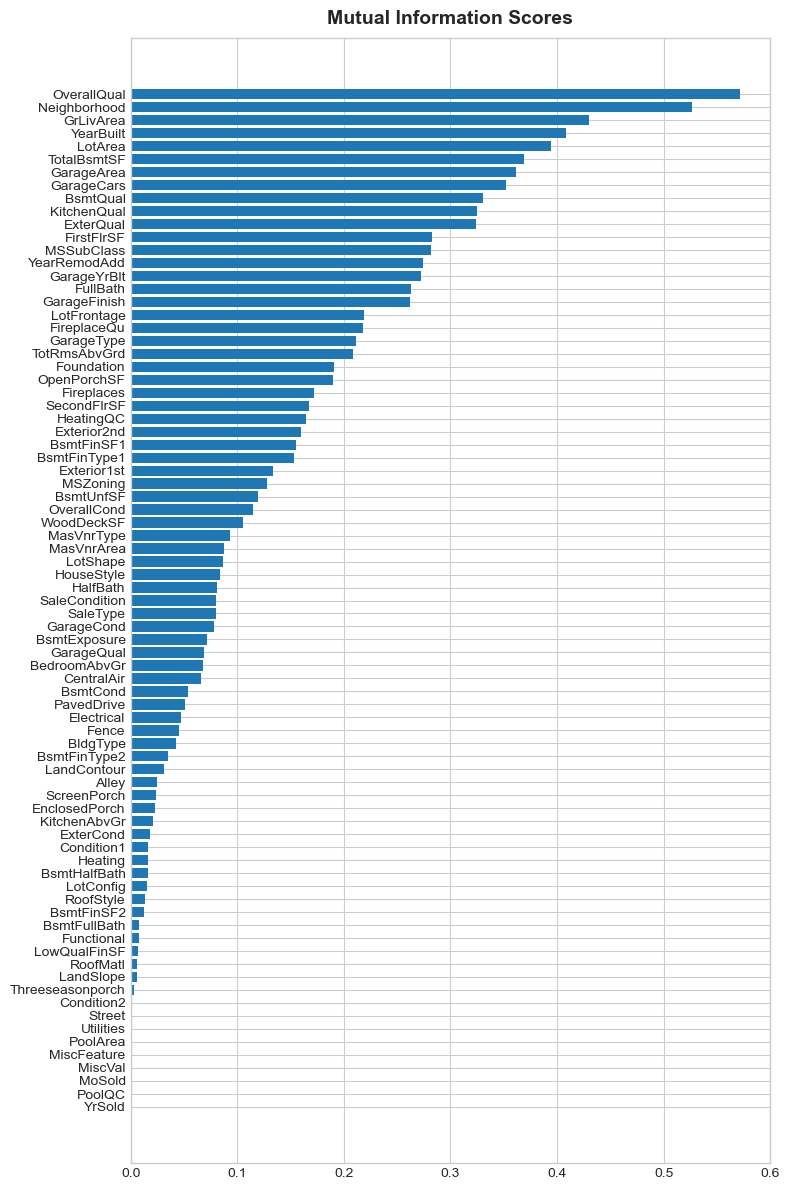

In [21]:
plt.figure(dpi=100, figsize=(8, 12))
plot_mi_scores(mi_scores)

You can see that we have a number of features that are highly informative and also some that don't seem to be informative at all (at least by themselves). The top scoring features will usually pay-off the most during feature development, so it could be a good idea to focus your efforts on those. On the other hand, training on uninformative features can lead to overfitting. So, the features with 0.0 scores we'll drop entirely:

In [22]:
def drop_uninformative(df, mi_scores):
    return df.loc[:, mi_scores > 0.0]


Remove uninformative features:

In [23]:
X = df_train.copy()
y = X.pop("SalePrice")
X = drop_uninformative(X, mi_scores)

score_dataset(X, y)

0.1441513588582852

Later, we'll add the `drop_uninformative` function to our feature-creation pipeline.

# Step 3 - Create Features

Now we'll start developing our feature set.

To make our feature engineering workflow more modular, we'll define a function that will take a prepared dataframe and pass it through a pipeline of transformations to get the final feature set. It will look something like this:

```
def create_features(df):
    X = df.copy()
    y = X.pop("SalePrice")
    X = X.join(create_features_1(X))
    X = X.join(create_features_2(X))
    X = X.join(create_features_3(X))
    # ...
    return X
```

## Create Features with Pandas

In the following, you need to apply strategies for creating features in Pandas. Add to these functions to try out other feature combinations.

### Mathematical Transformations

- define LivLotRatio feature as ration between the Above grade (ground) living area square feet (GrLivArea) and the Lot size in square feet (LotArea)
- define Spaciousness as the ration between the sum of first and second floor surfaces (FirstFlrSF, SecondFlrSF), divided by the total rooms above grade (TotRmsAbvGrd)

In [24]:
def mathematical_transforms(df):
    X = pd.DataFrame()  # dataframe to hold new features
    X["LivLotRatio"] = df.GrLivArea / df.LotArea
    X["Spaciousness"] = (df.FirstFlrSF + df.SecondFlrSF) / df.TotRmsAbvGrd
    return X


In [25]:
X = X.join(mathematical_transforms(X))
X

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,OpenPorchSF,EnclosedPorch,Threeseasonporch,ScreenPorch,PoolArea,Fence,SaleType,SaleCondition,LivLotRatio,Spaciousness
Id,,,,,,,,,,,,,,,,,,,,,
1,5,3,65.0,8450,1,2,1,3,3,4,...,61,0,0,0,0,0,8,4,0.202367,213.750000
2,0,3,80.0,9600,1,2,1,3,3,2,...,0,0,0,0,0,0,8,4,0.131458,210.333333
3,5,3,68.0,11250,1,2,2,3,3,4,...,42,0,0,0,0,0,8,4,0.158756,297.666667
4,6,3,60.0,9550,1,2,2,3,3,0,...,35,272,0,0,0,0,8,0,0.179791,245.285714
5,5,3,84.0,14260,1,2,2,3,3,2,...,84,0,0,0,0,0,8,4,0.154137,244.222222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,5,3,62.0,7917,1,2,1,3,3,4,...,40,0,0,0,0,0,8,4,0.208033,235.285714
1457,0,3,85.0,13175,1,2,1,3,3,4,...,0,0,0,0,0,3,8,4,0.157343,296.142857
1458,6,3,66.0,9042,1,2,1,3,3,4,...,60,0,0,0,0,4,8,4,0.258792,260.000000


### Interactions
- define a new feature for each BldgType that reports the GrLivArea if an house has that specific BldgType, 0 otherwise you might use the get_dummies() pandas function

**Hint**: you might need the Pandas mul function

In [26]:
def interactions(df):
    X = pd.get_dummies(df.BldgType, prefix="Bldg")
    X = X.mul(df.GrLivArea, axis=0)
    return X


In [27]:
X = X.join(interactions(X))
X

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,Fence,SaleType,SaleCondition,LivLotRatio,Spaciousness,Bldg_0,Bldg_1,Bldg_2,Bldg_3,Bldg_4
Id,,,,,,,,,,,,,,,,,,,,,
1,5,3,65.0,8450,1,2,1,3,3,4,...,0,8,4,0.202367,213.750000,1710,0,0,0,0
2,0,3,80.0,9600,1,2,1,3,3,2,...,0,8,4,0.131458,210.333333,1262,0,0,0,0
3,5,3,68.0,11250,1,2,2,3,3,4,...,0,8,4,0.158756,297.666667,1786,0,0,0,0
4,6,3,60.0,9550,1,2,2,3,3,0,...,0,8,0,0.179791,245.285714,1717,0,0,0,0
5,5,3,84.0,14260,1,2,2,3,3,2,...,0,8,4,0.154137,244.222222,2198,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,5,3,62.0,7917,1,2,1,3,3,4,...,0,8,4,0.208033,235.285714,1647,0,0,0,0
1457,0,3,85.0,13175,1,2,1,3,3,4,...,3,8,4,0.157343,296.142857,2073,0,0,0,0
1458,6,3,66.0,9042,1,2,1,3,3,4,...,4,8,4,0.258792,260.000000,2340,0,0,0,0


### Counts
- define a new feature that sums the Square Feets of the different types of porches (include WoodDeckSF)

In [28]:
def counts(df):
    X = pd.DataFrame()
    X["PorchTypes"] = df[[
        "WoodDeckSF",
        "OpenPorchSF",
        "EnclosedPorch",
        "Threeseasonporch",
        "ScreenPorch",
    ]].gt(0.0).sum(axis=1)
    return X


In [29]:
X = X.join(counts(X))
X

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,SaleType,SaleCondition,LivLotRatio,Spaciousness,Bldg_0,Bldg_1,Bldg_2,Bldg_3,Bldg_4,PorchTypes
Id,,,,,,,,,,,,,,,,,,,,,
1,5,3,65.0,8450,1,2,1,3,3,4,...,8,4,0.202367,213.750000,1710,0,0,0,0,1
2,0,3,80.0,9600,1,2,1,3,3,2,...,8,4,0.131458,210.333333,1262,0,0,0,0,1
3,5,3,68.0,11250,1,2,2,3,3,4,...,8,4,0.158756,297.666667,1786,0,0,0,0,1
4,6,3,60.0,9550,1,2,2,3,3,0,...,8,0,0.179791,245.285714,1717,0,0,0,0,2
5,5,3,84.0,14260,1,2,2,3,3,2,...,8,4,0.154137,244.222222,2198,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,5,3,62.0,7917,1,2,1,3,3,4,...,8,4,0.208033,235.285714,1647,0,0,0,0,1
1457,0,3,85.0,13175,1,2,1,3,3,4,...,8,4,0.157343,296.142857,2073,0,0,0,0,1
1458,6,3,66.0,9042,1,2,1,3,3,4,...,8,4,0.258792,260.000000,2340,0,0,0,0,1


###  Group Transformation
- define a new feature **MedNhbdArea** that is the median of the GrLivArea grouped by Neighborhood

**Hint:** use the Pandas transform function to [broadcast the values accross the groups](https://stackoverflow.com/questions/40957932/transform-vs-aggregate-in-pandas-groupby)

In [30]:
def group_transforms(df):
    X = pd.DataFrame()
    X["MedNhbdArea"] = df.groupby("Neighborhood")["GrLivArea"].transform("median")
    return X


In [31]:
X = X.join(group_transforms(X))
X

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,SaleCondition,LivLotRatio,Spaciousness,Bldg_0,Bldg_1,Bldg_2,Bldg_3,Bldg_4,PorchTypes,MedNhbdArea
Id,,,,,,,,,,,,,,,,,,,,,
1,5,3,65.0,8450,1,2,1,3,3,4,...,4,0.202367,213.750000,1710,0,0,0,0,1,1500.0
2,0,3,80.0,9600,1,2,1,3,3,2,...,4,0.131458,210.333333,1262,0,0,0,0,1,1437.0
3,5,3,68.0,11250,1,2,2,3,3,4,...,4,0.158756,297.666667,1786,0,0,0,0,1,1500.0
4,6,3,60.0,9550,1,2,2,3,3,0,...,0,0.179791,245.285714,1717,0,0,0,0,2,1717.0
5,5,3,84.0,14260,1,2,2,3,3,2,...,4,0.154137,244.222222,2198,0,0,0,0,2,2418.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,5,3,62.0,7917,1,2,1,3,3,4,...,4,0.208033,235.285714,1647,0,0,0,0,1,1593.0
1457,0,3,85.0,13175,1,2,1,3,3,4,...,4,0.157343,296.142857,2073,0,0,0,0,1,1664.0
1458,6,3,66.0,9042,1,2,1,3,3,4,...,4,0.258792,260.000000,2340,0,0,0,0,1,1717.0


Here are some ideas for other transforms you could explore:
- Interactions between the quality `Qual` and condition `Cond` features. `OverallQual`, for instance, was a high-scoring feature. You could try combining it with `OverallCond` by converting both to integer type and taking a product.
- Square roots of area features. This would convert units of square feet to just feet.
- Logarithms of numeric features. If a feature has a skewed distribution, applying a logarithm can help normalize it.
- Interactions between numeric and categorical features that describe the same thing. You could look at interactions between `BsmtQual` and `TotalBsmtSF`, for instance.
- Other group statistics in `Neighboorhood`. We did the median of `GrLivArea`. Looking at `mean`, `std`, or `count` could be interesting. You could also try combining the group statistics with other features. Maybe the *difference* of `GrLivArea` and the median is important?

## Principal Component Analysis ##

PCA can be used as an unsupervised model for feature creation. We saw how it could be used to decompose the variational structure in the data. The PCA algorithm give us *loadings* which described each component of variation, and also the *components* which are the transformed datapoints. The loadings can suggest features to create and the components we can use as features directly.

Here are utility functions to apply and plot PCA:

In [32]:
def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs


Let's choose a few features that are highly correlated with our target, SalePrice.

In [33]:
features = [
    "GarageArea",
    "YearRemodAdd",
    "TotalBsmtSF",
    "GrLivArea",
]

print("Correlation with SalePrice:\n")
print(df_train[features].corrwith(df_train.SalePrice))

Correlation with SalePrice:

GarageArea      0.623431
YearRemodAdd    0.507101
TotalBsmtSF     0.613581
GrLivArea       0.708624
dtype: float64


We'll rely on PCA to untangle the correlational structure of these features and suggest relationships that might be usefully modeled with new features.

Run this cell to apply PCA and extract the loadings.

In [34]:
X_features = X.loc[:, features]

# apply pca
pca, X_pca, loadings = apply_pca(X_features)
print(loadings)

                   PC1       PC2       PC3       PC4
GarageArea    0.542671  0.055849  0.172729 -0.820094
YearRemodAdd  0.418537 -0.883023 -0.052628  0.205735
TotalBsmtSF   0.518308  0.324224  0.617357  0.495082
GrLivArea     0.511558  0.334709 -0.765680  0.200032


Look at the loadings for components PC1 and PC3. Can you think of a description of what kind of contrast each component has captured?

Your goal is to use the results of PCA to discover one or more new features that improve the performance of your model. One option is to create features inspired by the loadings. Another option is to use the components themselves as features (that is, add one or more columns of X_pca to X).

Add one or more new features to the dataset X. For a correct solution, get a validation score below 0.140 RMSLE.

In [35]:
def pca_inspired(df):
    X = pd.DataFrame()
    X["Feature1"] = df.GrLivArea + df.TotalBsmtSF
    X["Feature2"] = df.YearRemodAdd * df.TotalBsmtSF
    return X


Ad the components themselves as features:

In [36]:
def pca_components(df, features):
    X = df.loc[:, features]
    _, X_pca, _ = apply_pca(X)
    return X_pca


## Create Final Feature Set

Now let's combine everything together. Putting the transformations into separate functions makes it easier to experiment with various combinations. You should experiment with you own ideas though! Modify any of these transformations or come up with some of your own to add to the pipeline.

In [37]:
def create_features(df, pca_features=None, df_test=None):
    X = df.copy()
    y = X.pop("SalePrice")
    mi_scores = make_mi_scores(X, y)

    # Combine splits if test data is given
    #
    # If we're creating features for test set predictions, we should
    # use all the data we have available. After creating our features,
    # we'll recreate the splits.
    if df_test is not None:
        X_test = df_test.copy()
        X_test.pop("SalePrice")
        X = pd.concat([X, X_test])

    # Mutual Information
    X = drop_uninformative(X, mi_scores)

    # Transformations
    X = X.join(mathematical_transforms(X))
    X = X.join(interactions(X))
    X = X.join(counts(X))
    X = X.join(group_transforms(X))

    # PCA
    X = X.join(pca_inspired(X))
    if pca_features is not None:
        X = X.join(pca_components(X, pca_features))

    # Reform splits
    if df_test is not None:
        X_test = X.loc[df_test.index, :]
        X.drop(df_test.index, inplace=True)
        
    if df_test is not None:
        return X, X_test
    else:
        return X


df_train, df_test = load_data()
pca_features = None
X_train = create_features(df_train, pca_features)
y_train = df_train.loc[:, "SalePrice"]

score_dataset(X_train, y_train)

0.13931459061172058